In [90]:
import pymongo
from pymongo import MongoClient
from bson.code import Code
import matplotlib.pyplot as plt
import mpld3
from pprint import pprint
import json
import datetime
import time
from IPython.display import Image, display
from IPython.core.display import HTML 
%matplotlib inline

In [4]:
client = MongoClient('mongodb://epic-analytics.cs.colorado.edu')

In [5]:
db = client.nepal_earthquake
print(db.collection_names())
tweets = db.tweets
users = db.users
tweets_per_day = db.tweets_per_day
tweets.count()

['system.indexes', 'tweets', 'users', 'tweets_per_day', 'unique_langs']


/usr/local/lib/python3.5/site-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/usr/local/lib/python3.5/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


24045885

### Count tweets with images

In [21]:
# tweets.find({"entities.media.media_url":{$exists: True, "$ne": None}})
tweets.count({"entities.media.media_url":{"$exists": True, "$ne": None}})

6506081

In [41]:
for index in tweets.list_indexes():
    print(index)

SON([('v', 1), ('name', '_id_'), ('key', SON([('_id', 1)])), ('ns', 'nepal_earthquake.tweets')])
SON([('v', 1), ('name', 'text_text'), ('key', SON([('_fts', 'text'), ('_ftsx', 1)])), ('ns', 'nepal_earthquake.tweets'), ('weights', SON([('text', 1)])), ('default_language', 'english'), ('language_override', 'language'), ('textIndexVersion', 1)])
SON([('v', 1), ('name', 'coordinates_2dsphere'), ('key', SON([('coordinates', '2dsphere')])), ('ns', 'nepal_earthquake.tweets')])
SON([('v', 1), ('name', 'created_at_1'), ('key', SON([('created_at', 1)])), ('ns', 'nepal_earthquake.tweets')])
SON([('v', 1), ('name', 'id_1'), ('key', SON([('id', 1)])), ('ns', 'nepal_earthquake.tweets')])
SON([('v', 1), ('name', 'retweet_count_1'), ('key', SON([('retweet_count', 1)])), ('ns', 'nepal_earthquake.tweets')])
SON([('v', 1), ('name', 'user.created_at_1'), ('key', SON([('user.created_at', 1)])), ('ns', 'nepal_earthquake.tweets')])
SON([('v', 1), ('name', 'user.id_1'), ('key', SON([('user.id', 1)])), ('ns', 

In [40]:
# tweets.create_index([("lang", pymongo.ASCENDING)])

'lang_1'

### Show most common languages of tweets (machine-interpreted)

In [49]:
cursor = tweets.aggregate([
    {"$group": { 
        "_id": '$lang',
        "count": {"$sum": 1}
    }},

    {"$sort": {
        "count": -1
    }},

    {"$limit": 10},
        
    {"$project": { 
        "language": '$_id', 
        "count": 1, 
        "_id": 0 
    }} 
]);

In [50]:
for document in cursor:
    print(document)

{'language': 'en', 'count': 14306366}
{'language': 'es', 'count': 2565572}
{'language': 'ne', 'count': 2048740}
{'language': 'in', 'count': 1227791}
{'language': 'hi', 'count': 1002601}
{'language': 'pt', 'count': 357889}
{'language': 'und', 'count': 343722}
{'language': 'tr', 'count': 330670}
{'language': 'fr', 'count': 266066}
{'language': 'it', 'count': 210453}


In [44]:
import itertools
mydict = {"a":1, "b":2, "c":3, "d":4}
print(list(itertools.combinations(mydict,2)))


[('c', 'b'), ('c', 'd'), ('c', 'a'), ('b', 'd'), ('b', 'a'), ('d', 'a')]


In [ ]:
# Find all tweets that have more than 10000 occurrences (retweets)
tweets.aggregate([ 
    {"$group": { 
        "_id": 'retweeted_status.id_str', 
        "count": {"$sum": 1} 
    }}, 

    {"$match": { 
        "count": {"$gt": 10000 } 
    }}, 

    {"$sort": { 
        "count": -1 
    }} 
]);

### Create geojson file from geotagged tweets

In [162]:
cursor = tweets.find(
    {"coordinates":{"$near":
                    {"$geometry":{"type":"Point", "coordinates":[85.324931,27.717618]}, "$maxDistance":50000}}
    },
#     {"coordinates":{"$exists":True, 
#                     "$ne":None,
#                     "$near":{"$geometry":{"type":"Point", "coordinates":[85.324931,27.717618]}, "$maxDistance":50000}}
#     },
    {"coordinates":1, "text":1, "_id":0}
).limit(100)

In [163]:
# test = [{"text": "Some people's lives have been turned upside down forever. My prayers goes to them. #NepalEarthquake",
#          "coordinates": {"type": "Point", "coordinates": [8.562547, 11.943377]}},
#         {"text": "Praying for all people affected by the #NepalEarthquake - I promise to return and help where I can. My prayers are with you.",
#          "coordinates": {"type": "Point", "coordinates": [-71.982914, -13.512962]}}
#        ]

# Create structure for GeoJSON feature collection object
tweet_geometries = {"type": "FeatureCollection", "features": [] }
for tweet in cursor:

    # Add a feature object to the features array for each tweet
    tweet_geometries['features'].append(
        {'type':'Feature',
         'geometry':tweet['coordinates'],
         'properties':{'text':tweet['text']}
        })
print(json.dumps(tweet_geometries))

with open('test.geojson', 'w') as outfile:
    json.dump(tweet_geometries, outfile)

{"type": "FeatureCollection", "features": [{"geometry": {"type": "Point", "coordinates": [85.323939, 27.717796]}, "type": "Feature", "properties": {"text": "IndianMedia showsIndia is the only country to help Nepal at thisEarthquakeBtCouldnt be even inTop14#GoHomeIndianMedia http://t.co/H6Buv0jHkU"}}, {"geometry": {"type": "Point", "coordinates": [85.323961, 27.717245]}, "type": "Feature", "properties": {"text": "@landward_rsrch is now in Nepal! Kenneth Aitchison will be in Kathmandu for 3 years contact details unchanged http://t.co/FKHwCKGEiw"}}, {"geometry": {"type": "Point", "coordinates": [85.323961, 27.717245]}, "type": "Feature", "properties": {"text": "Nepali hackers: Nepal's websites either gov or corporate or even personal all of them have been victims of hac... http://t.co/w5DHHmxjj6"}}, {"geometry": {"type": "Point", "coordinates": [85.323961, 27.717245]}, "type": "Feature", "properties": {"text": "Community Radio Stations a lifeline after Nepal earthquake https://t.co/GsoBs5

### Find all tweets geotagged "near" Kathmandu (27.717618, 85.324931) (with images)

In [178]:
cursor = tweets.find({"coordinates":{"$near":
                         {"$geometry":{"type":"Point", "coordinates":[85.324931,27.717618]}, "$maxDistance":50000}}#,
#                       "entities.media.media_url":{"$exists":True, "$ne": None}
                     }
                     {"coordinates":1, "text":1, "user.location":1, "entities.media.media_url":1, "_id":0}
                    ).limit(100)
for doc in cursor:
    pprint(doc)
print(cursor.count())

{'coordinates': {'coordinates': [85.323939, 27.717796], 'type': 'Point'},
 'entities': {'media': [{'media_url': 'http://pbs.twimg.com/media/CEKIMjwUEAA-Q48.jpg'}]},
 'text': 'IndianMedia showsIndia is the only country to help Nepal at '
         'thisEarthquakeBtCouldnt be even inTop14#GoHomeIndianMedia '
         'http://t.co/H6Buv0jHkU',
 'user': {'location': ''}}
{'coordinates': {'coordinates': [85.323961, 27.717245], 'type': 'Point'},
 'entities': {'media': [{'media_url': 'http://pbs.twimg.com/media/CM2Kmc2UwAIqpuv.jpg'}]},
 'text': '@landward_rsrch is now in Nepal! Kenneth Aitchison will be in '
         'Kathmandu for 3 years contact details unchanged '
         'http://t.co/FKHwCKGEiw',
 'user': {'location': 'London'}}
{'coordinates': {'coordinates': [85.32396, 27.717245], 'type': 'Point'},
 'entities': {'media': [{'media_url': 'http://pbs.twimg.com/media/CMjTEYEVEAA7kMC.jpg'}]},
 'text': 'Keepings of Kathmandu https://t.co/Hy7Qoa3Vo1 http://t.co/fr5eqdwIfC',
 'user': {'location

In [193]:
start = datetime.datetime(2015, 4, 25, 0, 0, 0)
end = datetime.datetime(2015, 6, 1, 0, 0, 0)

cursor = tweets.find({'created_at': {'$gte': start, '$lt': end}})
print(cursor.count())

# for doc in cursor:
#     print(doc)

12914430


### Find and plot tweets per day from 4/25/15 to 5/31/15

In [259]:
dates = []
counts = []
end = datetime.date(2015, 6, 1)

for tweet in tweets_per_day.find().sort("value.count", pymongo.DESCENDING):
#     print(tweet['_id'], tweet['value']['count'])
    date = datetime.datetime.strptime(tweet['_id'], "%m/%d/%Y").date()
    if date < end:
        dates.append(date)
        counts.append(tweet['value']['count'])

/usr/local/lib/python3.5/site-packages/dateutil/rrule.py:415: DeprecationWarning: Using both 'count' and 'until' is inconsistent with RFC 2445 and has been deprecated in dateutil. Future versions will raise an error.
  "raise an error.", DeprecationWarning)
/usr/local/lib/python3.5/site-packages/dateutil/rrule.py:415: DeprecationWarning: Using both 'count' and 'until' is inconsistent with RFC 2445 and has been deprecated in dateutil. Future versions will raise an error.
  "raise an error.", DeprecationWarning)
/usr/local/lib/python3.5/site-packages/dateutil/rrule.py:415: DeprecationWarning: Using both 'count' and 'until' is inconsistent with RFC 2445 and has been deprecated in dateutil. Future versions will raise an error.
  "raise an error.", DeprecationWarning)
/usr/local/lib/python3.5/site-packages/dateutil/rrule.py:415: DeprecationWarning: Using both 'count' and 'until' is inconsistent with RFC 2445 and has been deprecated in dateutil. Future versions will raise an error.
  "raise 

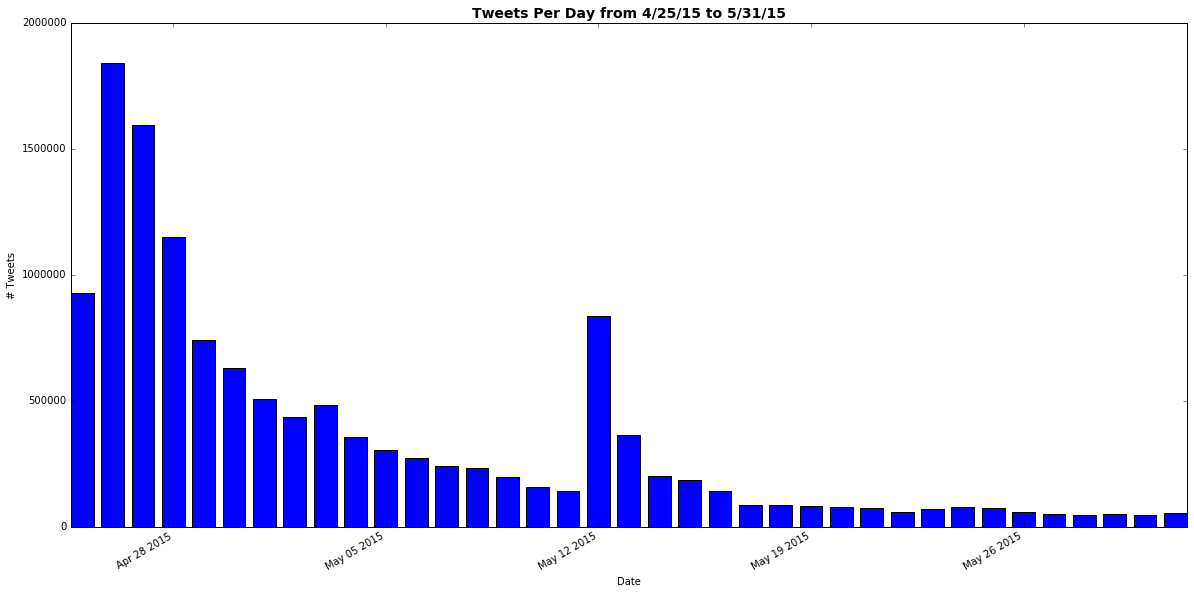

In [296]:
fig = plt.figure(figsize=(20,10))
ax = plt.subplot(111)
ax.bar(dates, counts, width=0.75, align='center')
# ax.xaxis_date()
fig.autofmt_xdate()

ax.set_title('Tweets Per Day from 4/25/15 to 5/31/15', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('# Tweets')

plt.savefig('tweetsperday.png')

### Find top 50 most retweeted images

In [61]:
# cursor = tweets.find({"entities.media.media_url":{"$exists":True, "$ne": None},
#                       "retweeted_status":{"$exists":True, "$ne": None}},
#                      {"retweeted_status.id":1, "_id":0}
#                     )
start = datetime.datetime(2015, 4, 25, 0, 0, 0)
end = datetime.datetime(2015, 6, 1, 0, 0, 0)

most_tweeted_images = list(tweets.aggregate([
    {"$match": {
        "entities.media.media_url":{"$exists":True, "$ne": None},
        "retweeted_status":{"$exists":True, "$ne": None},
        "created_at": {'$gte': start, '$lt': end} 
    }},
        
    {"$group": { 
        "_id": '$retweeted_status.id',
        "count": {"$sum": 1}
    }},

    {"$sort": {
        "count": -1
    }},

    {"$limit": 50}
]))

In [125]:
for doc in most_tweeted_images:
    print(json.dumps(doc))
#     cursor = tweets.find({"retweeted_status.id":doc['_id']},{"entities.media.media_url":1}).limit(1)
    # Find the original tweet
    if tweets.find_one({"id":doc['_id']}) != None:
        tweet = tweets.find_one({"id":doc['_id']})
    else:
        print("None")
    imgurl = tweet['entities']['media'][0]['media_url']
    print(imgurl)
    display(Image(url=str(imgurl)))

# json.dumps(most_tweeted_images)


{"_id": 593041414583414784, "count": 12187}
http://pbs.twimg.com/media/CDroBfoW0AEWS85.jpg


{"_id": 598052172312391680, "count": 8312}
http://pbs.twimg.com/media/CEy1Re_UsAEEUOe.jpg


{"_id": 595989727108444161, "count": 7915}
http://pbs.twimg.com/media/CEVfWweUMAE0Ltf.jpg


{"_id": 598221514345943040, "count": 7715}
http://pbs.twimg.com/media/CE1PHwQWgAEeKrb.jpg


{"_id": 601171857878953985, "count": 7205}
http://pbs.twimg.com/media/CFfKnnFUkAAmB1Z.jpg


{"_id": 596070919476420608, "count": 7198}
http://pbs.twimg.com/media/CEWrV5OUkAAWsHK.jpg


{"_id": 601397082902102016, "count": 6882}
http://pbs.twimg.com/media/CFiXdbiUsAEFAX7.jpg


{"_id": 592164258449756162, "count": 6826}
None
http://pbs.twimg.com/media/CFiXdbiUsAEFAX7.jpg


{"_id": 594219630308290560, "count": 6445}
http://pbs.twimg.com/media/CD8XmYaWoAA81Xw.jpg


{"_id": 592605726360608769, "count": 6396}
http://pbs.twimg.com/media/CDlbdEwWAAAmDMu.jpg


{"_id": 593851610415165441, "count": 5739}
http://pbs.twimg.com/media/CD3I4kqWgAAtop0.jpg


{"_id": 592926972365385729, "count": 5604}
http://pbs.twimg.com/media/CDp_8JoWYAAjypR.png


{"_id": 592001705132326913, "count": 4708}
http://pbs.twimg.com/media/CDc2afmWYAIPxaG.jpg


{"_id": 593632736453099521, "count": 4647}
http://pbs.twimg.com/media/CD0B1BQVEAAV3El.jpg


{"_id": 592519492200103936, "count": 4629}
http://pbs.twimg.com/media/CDkNVdRWMAANVEr.jpg


{"_id": 592865808130437120, "count": 4543}
http://pbs.twimg.com/media/CDpIT2IWgAITqe7.jpg


{"_id": 592102872780771328, "count": 4021}
http://pbs.twimg.com/media/CDeSbLHWYAA3IEJ.jpg


{"_id": 592020273718767617, "count": 3983}
None
http://pbs.twimg.com/media/CDeSbLHWYAA3IEJ.jpg


{"_id": 594712122703024128, "count": 3881}
http://pbs.twimg.com/media/CEDXhT-UsAELL_L.jpg


{"_id": 594108060378902529, "count": 3867}
None
http://pbs.twimg.com/media/CEDXhT-UsAELL_L.jpg


{"_id": 594298579612606464, "count": 3766}
http://pbs.twimg.com/media/CD9faMqUMAE_Q4z.jpg


{"_id": 592371640299728896, "count": 3737}
http://pbs.twimg.com/media/CDiG2yEVIAAURvh.jpg


{"_id": 591890107780599809, "count": 3696}
None
http://pbs.twimg.com/media/CDiG2yEVIAAURvh.jpg


{"_id": 593235512208424960, "count": 3601}
http://pbs.twimg.com/media/CDuYihQVIAEVY-1.jpg


{"_id": 592437743734493184, "count": 3550}
http://pbs.twimg.com/media/CDjC-ggVIAADM4W.jpg


{"_id": 594468083588149249, "count": 3516}
http://pbs.twimg.com/media/CD_5kQlUEAA8U7a.jpg


{"_id": 593258415402561536, "count": 3470}
http://pbs.twimg.com/media/CDutYrGUMAAb8Fr.jpg


{"_id": 602127764267749377, "count": 3403}
http://pbs.twimg.com/media/CFswAPlUMAAIsa2.jpg


{"_id": 592069184357412865, "count": 3374}
None
http://pbs.twimg.com/media/CFswAPlUMAAIsa2.jpg


{"_id": 592942921982279680, "count": 3262}
http://pbs.twimg.com/media/CDqN75mWEAAzABc.jpg


{"_id": 594133822259658752, "count": 3236}
http://pbs.twimg.com/media/CD7JjC3VEAALbP6.jpg


{"_id": 593763503288283136, "count": 3235}
http://pbs.twimg.com/media/CD13zBgW0AAJtYO.jpg


{"_id": 592056894052786176, "count": 3212}
http://pbs.twimg.com/media/CDdoibgUIAApaGW.jpg


{"_id": 593762686753583104, "count": 3138}
http://pbs.twimg.com/media/CD13-9JVAAAO3y0.jpg


{"_id": 592524867519545346, "count": 3128}
http://pbs.twimg.com/media/CDkSOjEUMAARQlC.jpg


{"_id": 594543607782051840, "count": 3057}
http://pbs.twimg.com/media/CEA-QFEUgAE9DUn.jpg


{"_id": 592298453860032512, "count": 3045}
http://pbs.twimg.com/media/CDhEMxsW0AABxCX.jpg


{"_id": 592366832457220096, "count": 3034}
http://pbs.twimg.com/media/CDiCftHWEAIEYYA.jpg


{"_id": 598033423693979648, "count": 3020}
http://pbs.twimg.com/media/CEyj9oOWEAER5sd.jpg


{"_id": 594589928505397248, "count": 2931}
http://pbs.twimg.com/media/CEBoY75W8AEQtww.jpg


{"_id": 596190859411984384, "count": 2834}
http://pbs.twimg.com/media/CEYYaPHWYAATmR1.jpg


{"_id": 604242484667883520, "count": 2758}
http://pbs.twimg.com/media/CGKzULBUQAAg0e0.jpg


{"_id": 597008123455361024, "count": 2622}
http://pbs.twimg.com/media/CEj_rgdWMAEJN9C.jpg


{"_id": 592063878575468544, "count": 2561}
None
http://pbs.twimg.com/media/CEj_rgdWMAEJN9C.jpg


{"_id": 592021482781483009, "count": 2481}
http://pbs.twimg.com/media/CDdIZSuWEAEMJfJ.jpg


{"_id": 592293676325347328, "count": 2432}
http://pbs.twimg.com/media/CDg_361UUAA4-2R.jpg


{"_id": 598077123639803904, "count": 2417}
http://pbs.twimg.com/media/CEzL-WVWEAAteV_.jpg


{"_id": 592755473377529857, "count": 2382}
http://pbs.twimg.com/media/CDnj9jkWgAAddGi.jpg


{"_id": 593168192186417152, "count": 2371}
None
http://pbs.twimg.com/media/CDnj9jkWgAAddGi.jpg


{"_id": 592013533174493184, "count": 2335}
None
http://pbs.twimg.com/media/CDnj9jkWgAAddGi.jpg


In [120]:
# tweets.find_one({"retweeted_status.id":592164258449756162},{"entities.media.media_url":1})
print(tweets.find_one({"id":592164258449756162}))

None


In [42]:
# without date limitations
# most_tweeted_images = [{'_id': 613861592292196352, 'count': 19102},
#                        {'_id': 613678855228817408, 'count': 17412},
#                        {'_id': 613773269880164352, 'count': 16434},
#                        {'_id': 593041414583414784, 'count': 13060},
#                        {'_id': 595989727108444161, 'count': 11821},
#                        {'_id': 610451744808640512, 'count': 11309},
#                        {'_id': 651106694781468672, 'count': 10104},
#                        {'_id': 613673956952948736, 'count': 9229},
#                        {'_id': 596070919476420608, 'count': 8917},
#                        {'_id': 609088840561778688, 'count': 8741}]

In [167]:
start = datetime.datetime(2015, 4, 25, 0, 0, 0)
end = datetime.datetime(2015, 5, 12, 0, 0, 0)

most_tweeted_images = list(tweets.aggregate([
    {"$match": {
        "entities.media.media_url":{"$exists":True, "$ne": None},
        "retweeted_status":{"$exists":True, "$ne": None},
        "created_at": {'$gte': start, '$lt': end} 
    }},
        
    {"$group": { 
        "_id": '$retweeted_status.id',
        "count": {"$sum": 1}
    }},

    {"$sort": {
        "count": -1
    }},

    {"$limit": 50}
]))

for doc in most_tweeted_images:
    print(json.dumps(doc))
#     cursor = tweets.find({"retweeted_status.id":doc['_id']},{"entities.media.media_url":1}).limit(1)
    # Find the original tweet
    if tweets.find_one({"id":doc['_id']}) != None:
        tweet = tweets.find_one({"id":doc['_id']})
    else:
        print("None")
    imgurl = tweet['entities']['media'][0]['media_url']
    print(imgurl)
    display(Image(url=str(imgurl)))

{"_id": 593041414583414784, "count": 10770}
http://pbs.twimg.com/media/CDroBfoW0AEWS85.jpg


{"_id": 592605726360608769, "count": 6393}
http://pbs.twimg.com/media/CDlbdEwWAAAmDMu.jpg


{"_id": 594219630308290560, "count": 6337}
http://pbs.twimg.com/media/CD8XmYaWoAA81Xw.jpg


{"_id": 595989727108444161, "count": 5784}
http://pbs.twimg.com/media/CEVfWweUMAE0Ltf.jpg


{"_id": 592926972365385729, "count": 5603}
http://pbs.twimg.com/media/CDp_8JoWYAAjypR.png


{"_id": 593851610415165441, "count": 5328}
http://pbs.twimg.com/media/CD3I4kqWgAAtop0.jpg


{"_id": 592001705132326913, "count": 4706}
http://pbs.twimg.com/media/CDc2afmWYAIPxaG.jpg


{"_id": 592164258449756162, "count": 4592}
None
http://pbs.twimg.com/media/CDc2afmWYAIPxaG.jpg


{"_id": 593632736453099521, "count": 4551}
http://pbs.twimg.com/media/CD0B1BQVEAAV3El.jpg


{"_id": 592865808130437120, "count": 4542}
http://pbs.twimg.com/media/CDpIT2IWgAITqe7.jpg


{"_id": 592102872780771328, "count": 4020}
http://pbs.twimg.com/media/CDeSbLHWYAA3IEJ.jpg


{"_id": 592020273718767617, "count": 3979}
None
http://pbs.twimg.com/media/CDeSbLHWYAA3IEJ.jpg


{"_id": 594712122703024128, "count": 3761}
http://pbs.twimg.com/media/CEDXhT-UsAELL_L.jpg


{"_id": 594298579612606464, "count": 3740}
http://pbs.twimg.com/media/CD9faMqUMAE_Q4z.jpg


{"_id": 592371640299728896, "count": 3712}
http://pbs.twimg.com/media/CDiG2yEVIAAURvh.jpg


{"_id": 593235512208424960, "count": 3599}
http://pbs.twimg.com/media/CDuYihQVIAEVY-1.jpg


{"_id": 592437743734493184, "count": 3542}
http://pbs.twimg.com/media/CDjC-ggVIAADM4W.jpg


{"_id": 593258415402561536, "count": 3464}
http://pbs.twimg.com/media/CDutYrGUMAAb8Fr.jpg


{"_id": 594468083588149249, "count": 3385}
http://pbs.twimg.com/media/CD_5kQlUEAA8U7a.jpg


{"_id": 592069184357412865, "count": 3361}
None
http://pbs.twimg.com/media/CD_5kQlUEAA8U7a.jpg


{"_id": 592942921982279680, "count": 3252}
http://pbs.twimg.com/media/CDqN75mWEAAzABc.jpg


{"_id": 593763503288283136, "count": 3225}
http://pbs.twimg.com/media/CD13zBgW0AAJtYO.jpg


{"_id": 592056894052786176, "count": 3195}
http://pbs.twimg.com/media/CDdoibgUIAApaGW.jpg


{"_id": 594133822259658752, "count": 3152}
http://pbs.twimg.com/media/CD7JjC3VEAALbP6.jpg


{"_id": 592524867519545346, "count": 3120}
http://pbs.twimg.com/media/CDkSOjEUMAARQlC.jpg


{"_id": 593762686753583104, "count": 3118}
http://pbs.twimg.com/media/CD13-9JVAAAO3y0.jpg


{"_id": 594108060378902529, "count": 3062}
None
http://pbs.twimg.com/media/CD13-9JVAAAO3y0.jpg


{"_id": 592298453860032512, "count": 3039}
http://pbs.twimg.com/media/CDhEMxsW0AABxCX.jpg


{"_id": 594543607782051840, "count": 3030}
http://pbs.twimg.com/media/CEA-QFEUgAE9DUn.jpg


{"_id": 592366832457220096, "count": 3027}
http://pbs.twimg.com/media/CDiCftHWEAIEYYA.jpg


{"_id": 591890107780599809, "count": 2942}
None
http://pbs.twimg.com/media/CDiCftHWEAIEYYA.jpg


{"_id": 594589928505397248, "count": 2898}
http://pbs.twimg.com/media/CEBoY75W8AEQtww.jpg


{"_id": 596190859411984384, "count": 2789}
http://pbs.twimg.com/media/CEYYaPHWYAATmR1.jpg


{"_id": 592063878575468544, "count": 2561}
None
http://pbs.twimg.com/media/CEYYaPHWYAATmR1.jpg


{"_id": 592021482781483009, "count": 2471}
http://pbs.twimg.com/media/CDdIZSuWEAEMJfJ.jpg


{"_id": 592293676325347328, "count": 2431}
http://pbs.twimg.com/media/CDg_361UUAA4-2R.jpg


{"_id": 592755473377529857, "count": 2380}
http://pbs.twimg.com/media/CDnj9jkWgAAddGi.jpg


{"_id": 592519492200103936, "count": 2363}
http://pbs.twimg.com/media/CDkNVdRWMAANVEr.jpg


{"_id": 591962067797712896, "count": 2321}
None
http://pbs.twimg.com/media/CDkNVdRWMAANVEr.jpg


{"_id": 597008123455361024, "count": 2316}
http://pbs.twimg.com/media/CEj_rgdWMAEJN9C.jpg


{"_id": 593168192186417152, "count": 2300}
None
http://pbs.twimg.com/media/CEj_rgdWMAEJN9C.jpg


{"_id": 592148438436990976, "count": 2264}
None
http://pbs.twimg.com/media/CEj_rgdWMAEJN9C.jpg


{"_id": 592186376424189953, "count": 2249}
http://pbs.twimg.com/media/CDfeXykW8AAx4Ll.jpg


{"_id": 591941496061964288, "count": 2208}
None
http://pbs.twimg.com/media/CDfeXykW8AAx4Ll.jpg


{"_id": 592705508190068737, "count": 2090}
None
http://pbs.twimg.com/media/CDfeXykW8AAx4Ll.jpg


{"_id": 592013533174493184, "count": 2087}
None
http://pbs.twimg.com/media/CDfeXykW8AAx4Ll.jpg


{"_id": 594256698216349696, "count": 2052}
http://pbs.twimg.com/media/CD85T3DUUAAERLu.jpg


{"_id": 592155088979800064, "count": 2051}
http://pbs.twimg.com/media/CDfB6g6UIAEW-FD.jpg


{"_id": 591988203013341184, "count": 1982}
http://pbs.twimg.com/media/CDcptrmUUAABIL1.jpg


{"_id": 594975162769870848, "count": 1956}
http://pbs.twimg.com/media/CEHGwg5UIAErEK0.jpg


In [168]:
# Count images in all tweets, tweets in Nepali, tweets in other languages, tweets geolocated in Nepal
start = datetime.datetime(2015, 4, 25, 0, 0, 0)
end = datetime.datetime(2015, 5, 12, 0, 0, 0)

tweets.count({"entities.media.media_url":{"$exists": True, "$ne": None},
              "created_at":{'$gte': start, '$lt': end}
             })

3047563

In [169]:
tweets.count({"entities.media.media_url":{"$exists": True, "$ne": None},
              "created_at":{'$gte': start, '$lt': end},
              "lang":"ne"
             })

25513

In [ ]:
tweets.count({"entities.media.media_url":{"$exists": True, "$ne": None},
              "created_at":{'$gte': start, '$lt': end},
              "lang":{"$ne":"ne"}
             })